# Setup


## Download Dependencies
The following cells need to be run to download the required dependencies for training the model

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CSE 538 Sarcasm Detection Project

/content/drive/.shortcut-targets-by-id/1ukrNqBuSEyi7NvE-D_MeJVb_6alN2R6h/CSE 538 Sarcasm Detection Project


In [8]:
!pip install transformers

In [9]:
!pip install datasets

     |████████████████████████████████| 298 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 56.1 MB/s 
     |████████████████████████████████| 1.1 MB 51.0 MB/s 
     |████████████████████████████████| 61 kB 438 kB/s 
     |████████████████████████████████| 243 kB 55.3 MB/s 
     |████████████████████████████████| 192 kB 61.7 MB/s 
     |████████████████████████████████| 160 kB 70.9 MB/s 
     |████████████████████████████████| 271 kB 62.1 MB/s 


In [13]:
!pip install emoji

     |████████████████████████████████| 170 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=2202a1098a41ccaac4968d6eab02369f93232454d2b6f87113d7981081cb794d
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [6]:
! rm -rf apex
! git clone https://github.com/NVIDIA/apex
! cd apex
! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Cloning into 'apex'...
remote: Enumerating objects: 8717, done.
remote: Counting objects: 100% (1085/1085), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 8717 (delta 963), reused 839 (delta 839), pack-reused 7632
Receiving objects: 100% (8717/8717), 14.38 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (5959/5959), done.
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/pytho

In [10]:
! pip install farasapy

In [11]:
! pip install pyarabic

In [4]:
! rm -rf arabert
! git clone https://github.com/aub-mind/arabert/

Cloning into 'arabert'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 556 (delta 182), reused 244 (delta 91), pack-reused 214
Receiving objects: 100% (556/556), 9.16 MiB | 36.06 MiB/s, done.
Resolving deltas: 100% (305/305), done.


In [5]:
!pip install PyArabic farasapy fast-bert

     |████████████████████████████████| 126 kB 5.1 MB/s 
     |████████████████████████████████| 99 kB 7.8 MB/s 
     |████████████████████████████████| 124 kB 48.1 MB/s 
     |████████████████████████████████| 769 kB 55.4 MB/s 
     |████████████████████████████████| 3.0 MB 60.6 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 895 kB 68.8 MB/s 
     |████████████████████████████████| 1.2 MB 61.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=2746f59b2735bf2f146f4b83e36c3dff430ee53f26322d4b0cb25affc469d568
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, ensemble, model_selection, preprocessing

from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
from fast_bert.metrics import F1
from fast_bert.data_cls import BertDataBunch
from fast_bert.prediction import BertClassificationPredictor

import torch, transformers, os, gc, random
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelWithLMHead
from transformers import TrainingArguments
from transformers import Trainer
from transformers import set_seed
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast

from farasa.segmenter import FarasaSegmenter
from arabert.preprocess import ArabertPreprocessor

import datasets
from datasets import load_metric
from datasets import list_datasets
from datasets import Dataset

import gc
import logging
import time
import warnings
import datetime
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [ ]:
from transformers import __version__
print("Transformers version:", __version__)
print("PyTorch version:", torch.__version__)

Transformers version: 3.0.2
PyTorch version: 1.10.0+cu111


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')    

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
# https://pytorch.org/docs/stable/notes/randomness.html

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Random Seed

In [ ]:
def set_random_seed(seed):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    

# Experiments with English Tweets



## Load Data

In [ ]:
dtypes = {
    'tweet' : 'str',
    'rephrase': 'str',
    'sarcastic': 'int64'
}

In [ ]:
df = pd.read_csv("dataset/train.En.csv", dtype=dtypes)

## Preprocessing

In [ ]:
df = df[df['tweet'].notna()]
df.reset_index(inplace=True)
print(df.shape)
df['rephrase'].fillna(' ', inplace=True)

(3467, 11)


In [ ]:
from bs4 import BeautifulSoup
import re
import itertools
import emoji


#####################################################################################
#
# DATA CLEANING
#
#####################################################################################

# emoticons
def load_dict_smileys():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

# self defined contractions
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }


def tweet_cleaning_for_sentiment_analysis(tweet):    
    
    #Escaping HTML characters
    tweet = BeautifulSoup(tweet).get_text()
   
    #Special case not handled previously.
    tweet = tweet.replace('\x92',"'")
    
    #Removal of hastags/account
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet).split())
    
    #Removal of address
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())
    
    #Removal of Punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    
    #Lower case
    tweet = tweet.lower()
    
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    tweet = tweet.replace("’","'")
    words = tweet.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    tweet = " ".join(reformed)
    
    # Standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    
    #Deal with emoticons source: https://en.wikipedia.org/wiki/List_of_emoticons
    SMILEY = load_dict_smileys()  
    words = tweet.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    tweet = " ".join(reformed)
    
    #Deal with emojis
    tweet = emoji.demojize(tweet)

    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())

    return tweet

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: tweet_cleaning_for_sentiment_analysis(x))

## EDA Data

In [ ]:
#more than double not sarcastic tweets -> need to train on this skewed class
df['sarcastic'].value_counts()

0    2600
1     867
Name: sarcastic, dtype: int64

In [ ]:
#all saracstic tweets have been rephrased
df[df['rephrase']!=' ']

,index,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,0,the only thing i got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,i love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,2,remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,3,today my pop pop told me i was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,4,i did too and i also reported cancun cruz not ...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
862,862,862,yo do yall do hysterectomies,1,"Claires, you should not do full hysterectomies.",1.0,0.0,0.0,0.0,0.0,1.0
863,863,863,do i need to aquire a wife before this happens...,1,A lot of people don't have a wife.,1.0,0.0,0.0,0.0,0.0,1.0
864,864,864,i get a lot of boy who cried wolf vibes from t...,1,The red cross is always needy.,0.0,1.0,0.0,0.0,0.0,0.0
865,865,865,update holding hands with your mom and walking...,1,Holding hands with your parent while walking a...,1.0,0.0,0.0,0.0,0.0,0.0


## Baseline

We tested out 2 baseline models for the set of english sarcastic tweets
* t5-base-fine-tuned-sarcasm-twitter
* distilbert-base-uncased

### T5 Evaluation Experiment
This model was already fine-tuned on sarcastic tweets. We evaluated it on our SemEval 2022 tweet dataset and got an accuracy of 0.58

In [ ]:
model = AutoModelWithLMHead.from_pretrained(model_name)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:698: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [ ]:
def eval_conversation(text):

  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids, max_length=3)
  
  dec = [tokenizer.decode(ids) for ids in output]

  label = dec[0]
  if 'derison' in label:
    return 1
  else:
    return 0
  return label

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP Project/train.En.csv")

In [ ]:
df['tweet'].fillna(' ')

0       The only thing I got from college is a caffein...
1       I love it when professors draw a big question ...
2       Remember the hundred emails from companies whe...
3       Today my pop-pop told me I was not “forced” to...
4       @VolphanCarol @littlewhitty @mysticalmanatee I...
                              ...                        
3463    The population spike in Chicago in 9 months is...
3464    You'd think in the second to last English clas...
3465    I’m finally surfacing after a holiday to Scotl...
3466    Couldn't be prouder today. Well done to every ...
3467    Overheard as my 13 year old games with a frien...
Name: tweet, Length: 3468, dtype: object

In [ ]:
train, test = model_selection.train_test_split(df, test_size=0.2, random_state = 42)
train_x = np.array(train.drop(['sarcastic'], axis=1))
x_label = np.array(train['sarcastic'])
test_y = np.array(test.drop(['sarcastic'], axis = 1))
y_label = np.array(test['sarcastic'])

In [ ]:
modified_df = df[['tweet', 'sarcastic', 'rephrase']]

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
modified_df['tweet'] = str(modified_df['tweet'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
label = []
for index in range(len(df['tweet'])):
  #print(df['tweet'][index])
  val = eval_conversation(df['tweet'][index])
  print(val, index)
  label.append(val)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
auc_score = roc_auc_score(label, df['sarcastic'])

In [ ]:
auc_score

0.5412361146532915

In [ ]:
df['rephrase'].fillna(' ', inplace=True)

In [ ]:
label_phrase = []
for index in range(len(df['tweet'])):
  #print(df['tweet'][index])
  val = eval_conversation(df['tweet'][index]+df['rephrase'][index])
  print(val, index)
  label_phrase.append(val)

In [ ]:
auc_score_2 = roc_auc_score(label_phrase, df['sarcastic'])
auc_score_2

0.5893206163062239

### DistilBERT Train & Evaluate

We did finetuning on 80-20 dataset split and validated on the remaining 20% dataset and got an accuracy of 0.73

So, we decided to move forward with distilBERT for further tuning

In [ ]:
train_texts = df['tweet'].apply(lambda x: tweet_cleaning_for_sentiment_analysis(x))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/jpgi5N4U9C" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [ ]:
train_labels = df['sarcastic']

In [ ]:
train_texts, val_texts, train_labels, val_labels = model_selection.train_test_split(train_texts, train_labels, test_size=.2)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(list(train_texts.values), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts.values), truncation=True, padding=True)

In [ ]:
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(train_encodings, list(train_labels.values))
val_dataset = SarcasmDataset(val_encodings, list(val_labels.values))

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 2773
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 261


Step,Training Loss
10,0.649000
20,0.625200
30,0.595100
40,0.556300
50,0.522700
60,0.577400
70,0.526000
80,0.571800
90,0.579100
100,0.499300




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=261, training_loss=0.47502028051464035, metrics={'train_runtime': 3083.0027, 'train_samples_per_second': 2.698, 'train_steps_per_second': 0.085, 'total_flos': 172186920221760.0, 'train_loss': 0.47502028051464035, 'epoch': 3.0})

In [ ]:
trainer.save_model('model_DB')

Saving model checkpoint to /content/drive/MyDrive/NLP Project/model_DB
Configuration saved in /content/drive/MyDrive/NLP Project/model_DB/config.json
Model weights saved in /content/drive/MyDrive/NLP Project/model_DB/pytorch_model.bin


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("model_DB", 
                                                            local_files_only=True)

loading configuration file /content/drive/MyDrive/NLP Project/model_DB/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/NLP Project/model_DB/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkp

In [ ]:
trainer.model = model
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 694
  Batch size = 32


{'epoch': 3.0,
 'eval_loss': 0.637362003326416,
 'eval_runtime': 78.0004,
 'eval_samples_per_second': 8.897,
 'eval_steps_per_second': 0.282}

In [ ]:
predictions = trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 694
  Batch size = 32


In [ ]:
preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
metric = datasets.load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

# for model_input, gold_references in evaluation_dataset:
#     model_predictions = model(model_inputs)
#     metric.add_batch(predictions=model_predictions, references=gold_references)

# final_score = metric.compute()

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

{'accuracy': 0.7305475504322767, 'f1': 0.2943396226415094}

### Demo

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("model_DB", 
                                                            local_files_only=True)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def eval_conversation(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')
  output = model(input_ids=input_ids)
  label = output[0].argmax().item()
  if label == 0:
    print("Not Sarcastic")
  else: 
    print("Sarcastic") 

In [ ]:
#correct

#expected sarcastic
eval_conversation(tweet_cleaning_for_sentiment_analysis("I love it when \
professors draw a big question mark next to my answer on an exam because \
I’m always like yeah I don’t either ¯\_(ツ)_/¯"))
eval_conversation(tweet_cleaning_for_sentiment_analysis("apparently it's the biggest ask on the planet to find decently priced sandals with an enclosed toe. PLEASE, INTERNET. I just want to have vaguely summery shoes that don't involve me having my toes out to the world at all times lmfaoo")) 

#expected not sarcastic 
eval_conversation(tweet_cleaning_for_sentiment_analysis("I just wanna lie in bed and eat skips and get paid for it")) 

Sarcastic
Sarcastic
Not Sarcastic


In [ ]:
#incorrect non sarcastic
eval_conversation(tweet_cleaning_for_sentiment_analysis("yall ever chip your tooth from accidentally biting your tongue ring"))

#expected sarcastic incorrect
eval_conversation(tweet_cleaning_for_sentiment_analysis("So staying up late was worth it..... 😪😩"))
eval_conversation(tweet_cleaning_for_sentiment_analysis("so many people pressed that italy won sorry eurovision belongs to the bisexuals now x #Eurovision"))

Sarcastic
Not Sarcastic
Not Sarcastic


## DistilBERT Hyperparameter Experiments

### Passing tweet & rephrase 
Trained for 3 epochs with 500 warmup steps
Batch size 16 & Eval Batch size 64
Learning Rate - 

In [ ]:
train_texts = feature_df.apply(lambda x: tweet_cleaning_for_sentiment_analysis(x))

In [ ]:
train_labels = df['sarcastic']

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(list(train_texts.values), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts.values), truncation=True, padding=True)

In [ ]:
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(train_encodings, list(train_labels.values))
val_dataset = SarcasmDataset(val_encodings, list(val_labels.values))

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 2773
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 522


Step,Training Loss
10,0.726000
20,0.708800
30,0.695400
40,0.674500
50,0.608800
60,0.590400
70,0.536000
80,0.565200
90,0.496200
100,0.486900


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=522, training_loss=0.29167809791263494, metrics={'train_runtime': 6423.0161, 'train_samples_per_second': 1.295, 'train_steps_per_second': 0.081, 'total_flos': 333612157929660.0, 'train_loss': 0.29167809791263494, 'epoch': 3.0})

In [ ]:
trainer.save_model('/content/drive/MyDrive/NLP Project/model/')

Saving model checkpoint to /content/drive/MyDrive/NLP Project/model
Configuration saved in /content/drive/MyDrive/NLP Project/model/config.json
Model weights saved in /content/drive/MyDrive/NLP Project/model/pytorch_model.bin


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP Project/model/", 
                                                            local_files_only=True)

loading configuration file /content/drive/MyDrive/NLP Project/model/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/NLP Project/model/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint a

In [ ]:
trainer.model = model
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 694
  Batch size = 64


{'eval_loss': 0.09180361777544022,
 'eval_runtime': 128.5369,
 'eval_samples_per_second': 5.399,
 'eval_steps_per_second': 0.086}

In [ ]:
eval_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
print("Validation" + '')
t0 = time.time()
total_eval_loss = 0
pred_flat = []
labels_flat = []
model.eval()
for batch in eval_loader:
  print(batch)
  b_input_ids = batch['input_ids']
  b_input_mask = batch['attention_mask']
  b_labels = batch['labels']
            
  with torch.no_grad():
                # (loss, logits) = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    outputt = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    loss = outputt[0]
    logits = outputt[1]

  total_eval_loss += loss.item()
  logits = logits.detach().numpy()
  label_ids = b_labels.numpy()

  pred_flat.extend(np.argmax(logits, axis=1).flatten())
  labels_flat.extend(label_ids.flatten())

Validation
{'input_ids': tensor([[ 101, 1045, 2572,  ...,    0,    0,    0],
        [ 101, 2042, 2652,  ...,    0,    0,    0],
        [ 101, 2061, 2085,  ...,    0,    0,    0],
        ...,
        [ 101, 2026, 2980,  ...,    0,    0,    0],
        [ 101, 3565, 4241,  ...,    0,    0,    0],
        [ 101, 1045, 3480,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1])}
{'input_ids': tensor([[  101,  2065,  2027,  ...,     0,     0,     0],
        [  101, 11611,  2003,  ...,     0,     0,     0],
        [  101, 23277,  3312,  ...,     0,     0,     0],
        ...,
        [  101,  2061,  3407,  ...,     0,     0,     0],
        [  101,  6819, 22280,  ...,     0,     0,     0],
        [  101,  2357,  24

NameError: ignored

In [ ]:
conf_matrix = confusion_matrix(labels_flat, pred_flat)
print("Confusion matrix- \n", conf_matrix)

acc_score = accuracy_score(labels_flat, pred_flat)
print('Accuracy Score: {0:.2f}'.format(acc_score))
TN, FP, FN, TP = conf_matrix.ravel()
print('True Positiva Rate: {0:.2f}'.format(TP / (TP + FN)))
avg_val_loss = total_eval_loss / len(eval_loader)
#validation_time = format_time(time.time() - t0)
print("Average validation Loss: {0:.2f}".format(avg_val_loss))
#print("Validation took: {:}".format(validation_time))
print('Report')
print(classification_report(labels_flat, pred_flat))
print("")
print("Training complete!")

Confusion matrix- 
 [[508   5]
 [ 11 170]]
Accuracy Score: 0.98
True Positiva Rate: 0.94
Average validation Loss: 0.09
Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       513
           1       0.97      0.94      0.96       181

    accuracy                           0.98       694
   macro avg       0.98      0.96      0.97       694
weighted avg       0.98      0.98      0.98       694


Training complete!


The Model was giving an F1 of 0.96 on which was very suspicious and indicated possible overtraining. So, we ran this on another twitter saracsm dataset to see how well the model would generalise

### Testing Model on Twitter SemEval 2018 
After doing this test, we analysed that the model was cheating in our original dataset and was overfit. We then tweaked the model architecture of original BERT where it performed best to check if model does better.

In [ ]:
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP Project/Twitter_Sarcasm_Detections-main/semeval18/test_cleaned - test_cleaned.csv')

In [ ]:
df.columns

Index(['tweet', 'sarcastic'], dtype='object')

In [ ]:
 val_texts, val_labels = df['tweet'], df['sarcastic']

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
val_encodings = tokenizer(list(val_texts.values), truncation=True, padding=True)

In [ ]:
val_dataset = SarcasmDataset(val_encodings, list(val_labels.values))

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP Project/model/", 
                                                            local_files_only=True)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.evaluate()

***** Running Evaluation *****
  Num examples = 780
  Batch size = 64


{'eval_loss': 2.2242484092712402,
 'eval_runtime': 25.9475,
 'eval_samples_per_second': 30.061,
 'eval_steps_per_second': 0.501}

In [ ]:
predictions = trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 780
  Batch size = 64


In [ ]:
predictions.label_ids.shape

(780,)

In [ ]:
from sklearn.metrics import roc_auc_score
acc = roc_auc_score(predictions.label_ids, val_labels)
acc

1.0

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
import datasets

metric = datasets.load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

{'accuracy': 0.9769452449567724, 'f1': 0.9550561797752809}

In [ ]:
import time

In [ ]:
from torch.utils.data import DataLoader
eval_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
print("Validation" + '')
t0 = time.time()
total_eval_loss = 0
pred_flat = []
labels_flat = []
model.eval()
for batch in eval_loader:
  b_input_ids = batch['input_ids']
  b_input_mask = batch['attention_mask']
  b_labels = batch['labels']     
  with torch.no_grad():
                # (loss, logits) = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    outputt = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    loss = outputt[0]
    logits = outputt[1]

  total_eval_loss += loss.item()
  logits = logits.detach().numpy()
  label_ids = b_labels.numpy()

  pred_flat.extend(np.argmax(logits, axis=1).flatten())
  labels_flat.extend(label_ids.flatten())

Validation


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import datetime
conf_matrix = confusion_matrix(labels_flat, pred_flat)
print("Confusion matrix- \n", conf_matrix)

acc_score = accuracy_score(labels_flat, pred_flat)
print('Accuracy Score: {0:.2f}'.format(acc_score))
TN, FP, FN, TP = conf_matrix.ravel()
print('True Positiva Rate: {0:.2f}'.format(TP / (TP + FN)))
avg_val_loss = total_eval_loss / len(eval_loader)
#validation_time = format_time(time.time() - t0)
print("Average validation Loss: {0:.2f}".format(avg_val_loss))
#print("Validation took: {:}".format(validation_time))
print('Report')
print(classification_report(labels_flat, pred_flat))
print("")
print("Training complete!")

Confusion matrix- 
 [[459  12]
 [300   9]]
Accuracy Score: 0.60
True Positiva Rate: 0.03
Average validation Loss: 2.23
Report
              precision    recall  f1-score   support

           0       0.60      0.97      0.75       471
           1       0.43      0.03      0.05       309

    accuracy                           0.60       780
   macro avg       0.52      0.50      0.40       780
weighted avg       0.53      0.60      0.47       780


Training complete!


### Demo

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("Over", 
                                                            local_files_only=True)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
def eval_conversation(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')
  output = model(input_ids=input_ids)
  label = output[0].argmax().item()
  if label == 0:
    print("Not Sarcastic")
  else: 
    print("Sarcastic") 

In [ ]:
#correct

#expected sarcastic
eval_conversation(tweet_cleaning_for_sentiment_analysis("I love it when \
professors draw a big question mark next to my answer on an exam because \
I’m always like yeah I don’t either ¯\_(ツ)_/¯"))
eval_conversation(tweet_cleaning_for_sentiment_analysis("apparently it's the biggest ask on the planet to find decently priced sandals with an enclosed toe. PLEASE, INTERNET. I just want to have vaguely summery shoes that don't involve me having my toes out to the world at all times lmfaoo")) 

#expected not sarcastic 
eval_conversation(tweet_cleaning_for_sentiment_analysis("I just wanna lie in bed and eat skips and get paid for it")) 

Not Sarcastic
Not Sarcastic
Not Sarcastic


In [ ]:
#incorrect non sarcastic
eval_conversation(tweet_cleaning_for_sentiment_analysis("yall ever chip your tooth from accidentally biting your tongue ring"))

#expected sarcastic incorrect
eval_conversation(tweet_cleaning_for_sentiment_analysis("So staying up late was worth it..... 😪😩"))
eval_conversation(tweet_cleaning_for_sentiment_analysis("so many people pressed that italy won sorry eurovision belongs to the bisexuals now x #Eurovision"))

Not Sarcastic
Not Sarcastic
Not Sarcastic


## DistilBERT Architecture - Concat 4 hidden layers and pass through a linear layer before classifying

### Dataset

In [ ]:
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, tokenizer, seq_len=512):        
        self.texts = texts #for train pass both rephrase & tweet
        self.targets = targets
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    
    def __len__(self):
        """Returns the length of dataset."""
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
        For a given item index, return a dictionary of encoded information        
        """        
        text = str(self.texts[idx]) 
        
        tokenized = self.tokenizer(
            text,            
            max_length = self.seq_len,                                
            padding = "max_length",     # Pad to the specified max_length. 
            truncation = True,          # Truncate to the specified max_length. 
            add_special_tokens = True,  # Whether to insert [CLS], [SEP], <s>, etc.   
            return_attention_mask = True            
        )     
        
        return {"ids": torch.tensor(tokenized["input_ids"], dtype=torch.long),
                "masks": torch.tensor(tokenized["attention_mask"], dtype=torch.long),
                "target": torch.tensor(self.targets[idx], dtype=torch.float)
               }

### Model

In [ ]:
class SarcasmModel(nn.Module):
    def __init__(self):        
        super().__init__() 
        self.bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Linear(3072, 2)     
    
    def forward(self, input_ids, attention_mask):       
        raw_output = self.bert_model(input_ids, attention_mask, 
                                        return_dict=True, output_hidden_states=True)
        hidden_states = raw_output["hidden_states"]
        pooled_output = torch.cat(tuple([hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
        pooled_output = pooled_output[:, 0, :]
        output = self.classifier(pooled_output) # Shape is [batch_size, 2]
        return output

### Train Function

In [ ]:
def loss_fn(predictions, targets):
    criterion = torch.nn.BCEWithLogitsLoss()
    return criterion(predictions, targets)

In [ ]:
import tqdm
def train_fn(data_loader, model, optimizer, device, scheduler):
        
    model.train()                               # Put the model in training mode.               
    
    lr_list = []
    train_losses = [] 
       
    for batch in tqdm.tqdm(data_loader):                   # Loop over all batches.
        
        ids = batch["ids"].to(device, dtype=torch.long)
        masks = batch["masks"].to(device, dtype=torch.long)
        targets = batch["target"].to(device, dtype=torch.float) 
        
        optimizer.zero_grad()                   # To zero out the gradients.
        
        outputs = model(ids, masks)[:, 1].ravel() # Predictions from 1 batch of data.
        # print(outputs)
        # print(targets[:, -1])
        loss = loss_fn(outputs, targets[:, -1])        # Get the training loss.
        train_losses.append(loss.item())
        loss.backward()                         # To backpropagate the error (gradients are computed).
        optimizer.step()                        # To update parameters based on current gradients.
        lr_list.append(optimizer.param_groups[0]["lr"])
        scheduler.step()                        # To update learning rate.
        
    return train_losses, lr_list

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import datetime

def validate_fn(data_loader, model, device):
    
    model.eval()                                    # Put model in evaluation mode.
    #p = nn.Softmax(dim=0)
    val_losses = []
    pred_flat = []
    labels_flat = []    
    with torch.no_grad():                           # Disable gradient calculation.
        
        for batch in tqdm.tqdm(data_loader):                   # Loop over all batches.   
            #print(batch)
            ids = batch["ids"].to(device, dtype=torch.long)
            masks = batch["masks"].to(device, dtype=torch.long)
            targets = batch["target"].to(device, dtype=torch.float)
            #print(targets, len(targets))
            outputs = model(ids, masks)[:, 1].ravel() # Predictions from 1 batch of data.
            
            #print(outputs, len(outputs))
            loss = loss_fn(outputs, targets[:, -1]) # Get the validation loss.
            val_losses.append(loss.item())
            #outputs = p(outputs)
            outputs = outputs.cpu().numpy()
            label_ids = targets[:, -1].cpu().numpy()
            #print(len(outputs), len(label_ids))
            #print(np.argmax(outputs).shape) # [64,2]
            #pred_flat.extend(np.argmax(outputs).flatten()) ORIGINAL
            
            pred_flat.extend(outputs)
            #print(len(pred_flat)) # incrementing by 1 (total = 19)
            labels_flat.extend(label_ids)
            #print(len(labels_flat)) # incrementing by 64 and last is 4 (total = 1156) 
    
    pred_flat = list(map(lambda x: 0 if x < -1 else 1, pred_flat)) 
    print(set(labels_flat))
    print('---')
    print(max(pred_flat), min(pred_flat))
    print_rep(labels_flat, pred_flat)  
    return val_losses, pred_flat, labels_flat

def print_rep(labels_flat, pred_flat):
  conf_matrix = confusion_matrix(labels_flat, pred_flat)
  print("Confusion matrix- \n", conf_matrix)
  acc_score = accuracy_score(labels_flat, pred_flat)
  print('Accuracy Score: {0:.2f}'.format(acc_score))
  TN, FP, FN, TP = conf_matrix.ravel()
  print('True Positive Rate: {0:.2f}'.format(TP / (TP + FN)))
  print('Report')
  print(classification_report(labels_flat, pred_flat))
  print("")

In [ ]:
def plot_lr_schedule(learning_rates):
    x = np.arange(len(learning_rates))
    plt.plot(x, learning_rates)
    plt.title(f'Linear schedule')
    plt.ylabel("Learning Rate")
    plt.xlabel("Training Steps")
    plt.show()

In [ ]:
def plot_train_val_losses(train_losses, val_losses, fold):
    x = np.arange(len(train_losses))
    plt.plot(x, train_losses, label="training loss", marker='o')
    plt.plot(x, val_losses, label="validation loss", marker='o')
    plt.legend(loc="best")   # to show the labels.
    plt.title(f'Fold {fold}: distilBERT-base')    
    plt.ylabel("Cross Entropy Loss")
    plt.xlabel(f"Epoch")    
    plt.show()

### Train & Eval dataset


In [ ]:
set_random_seed(3377)
skf = StratifiedKFold(n_splits = 3)

In [ ]:
feature_df = df[['tweet', 'rephrase']]
feature_df

,tweet,rephrase
0,the only thing i got from college is a caffein...,"College is really difficult, expensive, tiring..."
1,i love it when professors draw a big question ...,I do not like when professors don’t write out ...
2,remember the hundred emails from companies whe...,"I, at the bare minimum, wish companies actuall..."
3,today my pop pop told me i was not “forced” to...,"Today my pop-pop told me I was not ""forced"" to..."
4,i did too and i also reported cancun cruz not ...,I would say Ted Cruz is an asshole and doesn’t...
...,...,...
3462,the population spike in chicago in 9 months is...,
3463,you would think in the second to last english ...,
3464,i'm finally surfacing after a holiday to scotl...,
3465,could not be prouder today well done to every ...,


In [ ]:
import random as rd
#make a list of lists 
l = []
for index, row in feature_df.iterrows():
  t = []
  t.append(row['tweet'] + '. ')
  t.append(row['rephrase'])
  l.append(t)
#shuffle each list randomly
for item in l:
  random.shuffle(item) 
#input that to model
feature_df['text'] = [x[0]+x[1] for x in l]
feature_df

,tweet,rephrase,text
0,the only thing i got from college is a caffein...,"College is really difficult, expensive, tiring...",the only thing i got from college is a caffein...
1,i love it when professors draw a big question ...,I do not like when professors don’t write out ...,i love it when professors draw a big question ...
2,remember the hundred emails from companies whe...,"I, at the bare minimum, wish companies actuall...",remember the hundred emails from companies whe...
3,today my pop pop told me i was not “forced” to...,"Today my pop-pop told me I was not ""forced"" to...",today my pop pop told me i was not “forced” to...
4,i did too and i also reported cancun cruz not ...,I would say Ted Cruz is an asshole and doesn’t...,I would say Ted Cruz is an asshole and doesn’t...
...,...,...,...
3462,the population spike in chicago in 9 months is...,,the population spike in chicago in 9 months i...
3463,you would think in the second to last english ...,,you would think in the second to last english ...
3464,i'm finally surfacing after a holiday to scotl...,,i'm finally surfacing after a holiday to scot...
3465,could not be prouder today well done to every ...,,could not be prouder today well done to every ...


In [ ]:
train_labels = df['sarcastic']

In [ ]:
all_train_losses = []
all_val_losses = []
all_lr = []
def run_training():  
    
    EPOCHS = 3
    TRAIN_BS = 16             # Training batch size     
    VAL_BS = 64               # Validation batch size  
    EARLY_STOP_THRESHOLD = 3
    fold = 1
    min_loss = 1000
    early_stopping_counter = 0
    #=========================================================================
    # Prepare data and model for training
    #=========================================================================
    
    # Initialize the tokenizer
    tokenizer =  DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    for train_index, test_index in skf.split(feature_df, train_labels):
        set_random_seed(3377)
        df_train, df_val = feature_df[feature_df.index.isin(train_index)].reset_index(), feature_df[feature_df.index.isin(test_index)].reset_index()
        y_train_fold, y_test_fold = train_labels[train_index].reset_index(), train_labels[test_index].reset_index()

        # Initialize training dataset
        train_dataset = SarcasmDataset(texts = df_train["text"].values,
                                  targets = list(y_train_fold.values),
                                  tokenizer = tokenizer)

        # Initialize validation dataset
        val_dataset = SarcasmDataset(texts = df_val["tweet"].values,
                                targets = list(y_test_fold.values),
                                tokenizer = tokenizer)
        # Create training dataloader
        train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BS,
                                       shuffle = True, num_workers = 2)

        # Create validation dataloader
        val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                     shuffle = False, num_workers = 2)
        # Initialize the cuda device (or use CPU if you don't have GPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Load model and send it to the device.        
        model = SarcasmModel().to(device)
        
        # Get the AdamW optimizer
        optimizer = transformers.AdamW(model.parameters(), lr=1e-6)

        # Calculate the number of training steps (this is used by scheduler).
        # training steps = [number of batches] x [number of epochs].
        train_steps = int(len(df_train) / TRAIN_BS * EPOCHS)    
        print("TRAIN STEPS " + str(train_steps))
        # Get the learning rate scheduler    
        scheduler = transformers.get_scheduler(
                        "linear",    # Create a schedule with a learning rate that decreases linearly 
                                     # from the initial learning rate set in the optimizer to 0.
                        optimizer = optimizer,
                        num_warmup_steps = 50,
                        num_training_steps = train_steps)

        #=========================================================================
        # Training Loop - Start training the epochs
        #=========================================================================      
        # IMPLEMENT EARLY TERMINATE
        for epoch in range(EPOCHS):
          
            # Call the train function and get the training loss
            train_losses, lr_list = train_fn(train_data_loader, model, optimizer, device, scheduler)
            train_loss = np.mean(train_losses)   
            all_train_losses.append(train_loss)
            all_lr.extend(lr_list)

            # Perform validation and get the validation loss
            val_losses = validate_fn(val_data_loader, model, device)
            val_loss = np.mean(val_losses)
            all_val_losses.append(val_loss) 
            if val_loss < min_loss:            
                torch.save(model.state_dict(), 'model/bert-{}.pth'.format(fold))
                print(f"FOLD: {fold}, Epoch: {epoch}, Loss = {round(val_loss,4)}, checkpoint saved.")
                min_loss = val_loss
                early_stopping_counter = 0
            else:
                print(f"FOLD: {fold}, Epoch: {epoch}, Loss = {round(val_loss,4)}")
                early_stopping_counter += 1
            if early_stopping_counter > EARLY_STOP_THRESHOLD:
                print(f"FOLD: {fold}, Epoch: {epoch}, Loss = {round(val_loss,4)}")
                print(f"Early stopping triggered! Best Loss: {round(val_loss,4)}\n")                
                break
        # torch.save(model.state_dict(), 'model/bert-{}.pth'.format(fold))
        # Plot the losses and learning rate schedule.
        plot_train_val_losses(all_train_losses, all_val_losses, fold)
        plot_lr_schedule(all_lr) 
        fold += 1

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 324


100%|██████████| 109/109 [02:30<00:00,  1.38s/it]


FOLD: 1, Epoch: 0, Loss = 0.7078, checkpoint saved.


100%|██████████| 109/109 [02:30<00:00,  1.39s/it]


FOLD: 1, Epoch: 1, Loss = 1.1063


100%|██████████| 109/109 [02:30<00:00,  1.38s/it]


FOLD: 1, Epoch: 2, Loss = 1.6618


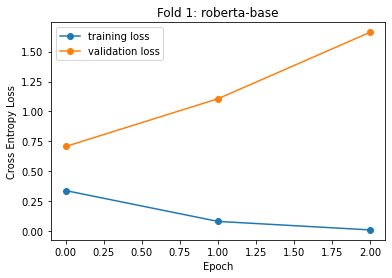

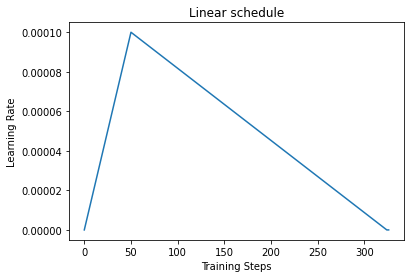

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 325


100%|██████████| 109/109 [02:29<00:00,  1.37s/it]


FOLD: 2, Epoch: 0, Loss = 1.2279


100%|██████████| 109/109 [02:29<00:00,  1.37s/it]


FOLD: 2, Epoch: 1, Loss = 1.5276
FOLD: 2, Epoch: 1, Loss = 1.5276
Early stopping triggered! Best Loss: 1.5276



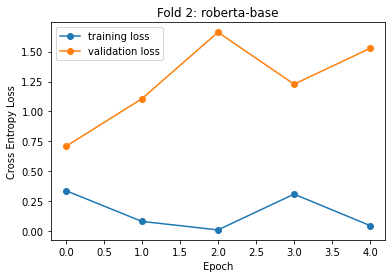

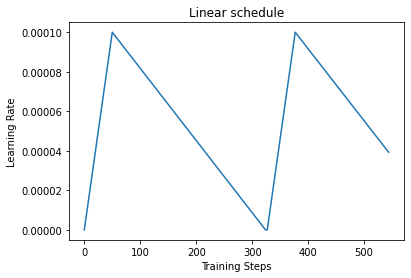

CPU times: user 17min 19s, sys: 7.98 s, total: 17min 27s
Wall time: 17min 50s


In [ ]:
%%time
#10^-4
if __name__ == "__main__":
    run_training()    

In [ ]:
all_train_losses = []
all_val_losses = []
all_lr = []
def run_training_tweet():  
    
    EPOCHS = 3
    TRAIN_BS = 16             # Training batch size     
    VAL_BS = 64               # Validation batch size  
    EARLY_STOP_THRESHOLD = 3
    fold = 1
    min_loss = 1000
    early_stopping_counter = 0
    #=========================================================================
    # Prepare data and model for training
    #=========================================================================
    
    # Initialize the tokenizer
    tokenizer =  DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    for train_index, test_index in skf.split(feature_df, train_labels):
        set_random_seed(3377)
        df_train, df_val = feature_df[feature_df.index.isin(train_index)].reset_index(), feature_df[feature_df.index.isin(test_index)].reset_index()
        y_train_fold, y_test_fold = train_labels[train_index].reset_index(), train_labels[test_index].reset_index()

        # Initialize training dataset
        train_dataset = SarcasmDataset(texts = df_train["tweet"].values,
                                  targets = list(y_train_fold.values),
                                  tokenizer = tokenizer)

        # Initialize validation dataset
        val_dataset = SarcasmDataset(texts = df_val["tweet"].values,
                                targets = list(y_test_fold.values),
                                tokenizer = tokenizer)
        # Create training dataloader
        train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BS,
                                       shuffle = True, num_workers = 2)

        # Create validation dataloader
        val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                     shuffle = False, num_workers = 2)
        # Initialize the cuda device (or use CPU if you don't have GPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Load model and send it to the device.        
        model = SarcasmModel().to(device)
        
        # Get the AdamW optimizer
        optimizer = transformers.AdamW(model.parameters(), lr=1e-6)

        # Calculate the number of training steps (this is used by scheduler).
        # training steps = [number of batches] x [number of epochs].
        train_steps = int(len(df_train) / TRAIN_BS * EPOCHS)    
        print("TRAIN STEPS " + str(train_steps))
        # Get the learning rate scheduler    
        scheduler = transformers.get_scheduler(
                        "linear",    # Create a schedule with a learning rate that decreases linearly 
                                     # from the initial learning rate set in the optimizer to 0.
                        optimizer = optimizer,
                        num_warmup_steps = 50,
                        num_training_steps = train_steps)

        #=========================================================================
        # Training Loop - Start training the epochs
        #=========================================================================      
        # IMPLEMENT EARLY TERMINATE
        for epoch in range(EPOCHS):
          
            # Call the train function and get the training loss
            train_losses, lr_list = train_fn(train_data_loader, model, optimizer, device, scheduler)
            train_loss = np.mean(train_losses)   
            all_train_losses.append(train_loss)
            all_lr.extend(lr_list)

            # Perform validation and get the validation loss
            val_losses = validate_fn(val_data_loader, model, device)
            val_loss = np.mean(val_losses)
            all_val_losses.append(val_loss) 
            if val_loss < min_loss:            
                torch.save(model.state_dict(), 'model/bert-tweet-{}.pth'.format(fold))
                print(f"FOLD: {fold}, Epoch: {epoch}, Loss = {round(val_loss,4)}, checkpoint saved.")
                min_loss = val_loss
                early_stopping_counter = 0
            else:
                print(f"FOLD: {fold}, Epoch: {epoch}, Loss = {round(val_loss,4)}")
                early_stopping_counter += 1
            if early_stopping_counter > EARLY_STOP_THRESHOLD:
                print(f"FOLD: {fold}, Epoch: {epoch}, Loss = {round(val_loss,4)}")
                print(f"Early stopping triggered! Best Loss: {round(val_loss,4)}\n")                
                break
        # torch.save(model.state_dict(), 'model/bert-{}.pth'.format(fold))
        # Plot the losses and learning rate schedule.
        plot_train_val_losses(all_train_losses, all_val_losses, fold)
        plot_lr_schedule(all_lr) 
        fold += 1

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 433


100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


FOLD: 1, Epoch: 0, Loss = 0.5337, checkpoint saved.


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]


FOLD: 1, Epoch: 1, Loss = 0.5728


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]


FOLD: 1, Epoch: 2, Loss = 0.7227


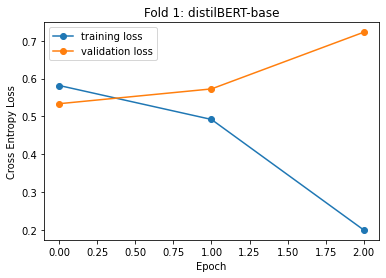

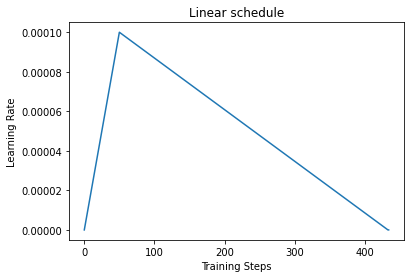

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 433


100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


FOLD: 2, Epoch: 0, Loss = 0.5384


100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


FOLD: 2, Epoch: 1, Loss = 0.6309
FOLD: 2, Epoch: 1, Loss = 0.6309
Early stopping triggered! Best Loss: 0.6309



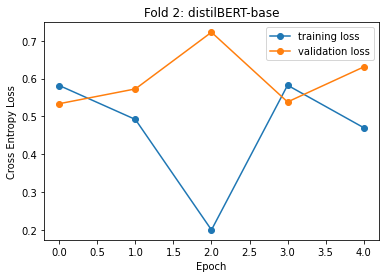

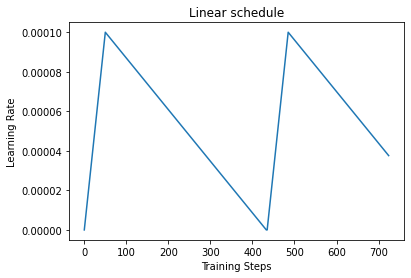

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 433


100%|██████████| 19/19 [00:37<00:00,  1.98s/it]


FOLD: 3, Epoch: 0, Loss = 0.5487
FOLD: 3, Epoch: 0, Loss = 0.5487
Early stopping triggered! Best Loss: 0.5487



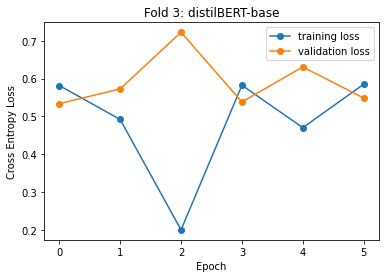

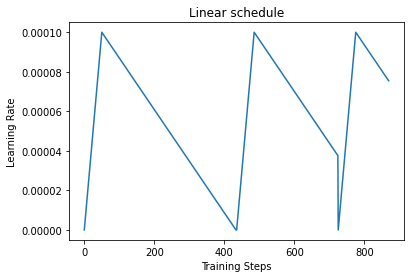

CPU times: user 23min 44s, sys: 6.89 s, total: 23min 51s
Wall time: 24min 4s


In [ ]:
%%time
#10^-4
if __name__ == "__main__":
    run_training_tweet()    

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 433


100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


FOLD: 1, Epoch: 0, Loss = 0.5813, checkpoint saved.


100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


FOLD: 1, Epoch: 1, Loss = 0.5552, checkpoint saved.


100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


FOLD: 1, Epoch: 2, Loss = 0.5535, checkpoint saved.


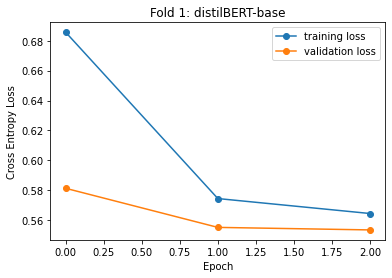

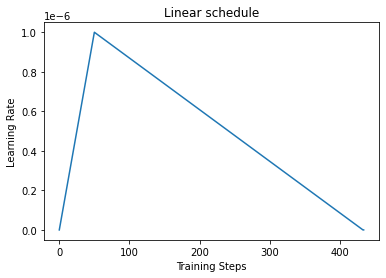

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 433


100%|██████████| 19/19 [00:38<00:00,  2.01s/it]


FOLD: 2, Epoch: 0, Loss = 0.5826


100%|██████████| 19/19 [00:37<00:00,  1.98s/it]


FOLD: 2, Epoch: 1, Loss = 0.5567


100%|██████████| 19/19 [00:37<00:00,  2.00s/it]


FOLD: 2, Epoch: 2, Loss = 0.555


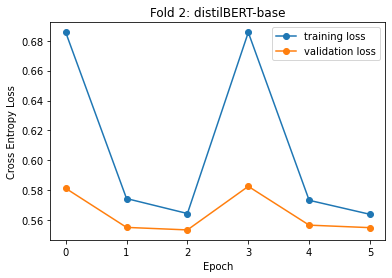

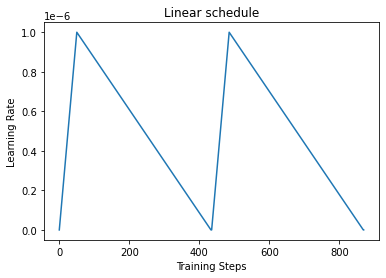

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TRAIN STEPS 433


100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


FOLD: 3, Epoch: 0, Loss = 0.583
FOLD: 3, Epoch: 0, Loss = 0.583
Early stopping triggered! Best Loss: 0.583



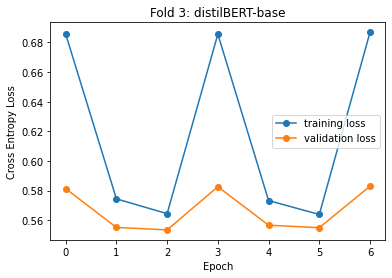

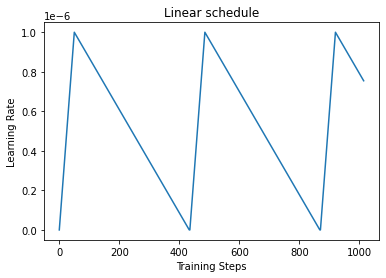

CPU times: user 27min 47s, sys: 8.91 s, total: 27min 56s
Wall time: 28min 11s


In [ ]:
%%time
# 10^-6
if __name__ == "__main__":
    run_training_tweet()    

In [ ]:
import gc
gc.collect()

6137

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   10757 MB |   10781 MB |   14552 MB |    3795 MB |\n|       from large pool |   10755 MB |   10779 MB |   14550 MB |    3795 MB |\n|       from small pool |       2 MB |       2 MB |       2 MB |       0 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   10757 MB |   10781 MB |   14552 MB |    3795 MB |\n|       from large pool |   10755 MB |   10779 MB |

In [ ]:
import time

In [ ]:
feature_df

,tweet,rephrase,text
0,the only thing i got from college is a caffein...,"College is really difficult, expensive, tiring...",the only thing i got from college is a caffein...
1,i love it when professors draw a big question ...,I do not like when professors don’t write out ...,i love it when professors draw a big question ...
2,remember the hundred emails from companies whe...,"I, at the bare minimum, wish companies actuall...",remember the hundred emails from companies whe...
3,today my pop pop told me i was not “forced” to...,"Today my pop-pop told me I was not ""forced"" to...",today my pop pop told me i was not “forced” to...
4,i did too and i also reported cancun cruz not ...,I would say Ted Cruz is an asshole and doesn’t...,I would say Ted Cruz is an asshole and doesn’t...
...,...,...,...
3462,the population spike in chicago in 9 months is...,,the population spike in chicago in 9 months i...
3463,you would think in the second to last english ...,,you would think in the second to last english ...
3464,i'm finally surfacing after a holiday to scotl...,,i'm finally surfacing after a holiday to scot...
3465,could not be prouder today well done to every ...,,could not be prouder today well done to every ...


In [ ]:
train_labels

0       1
1       1
2       1
3       1
4       1
       ..
3462    0
3463    0
3464    0
3465    0
3466    0
Name: sarcastic, Length: 3467, dtype: int64

In [ ]:
def predict(path):
  tokenizer =  DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
  VAL_BS = 64
  for train_index, test_index in skf.split(feature_df, train_labels):
          set_random_seed(3377)
          df_train, df_val = feature_df[feature_df.index.isin(train_index)].reset_index(), feature_df[feature_df.index.isin(test_index)].reset_index()
          y_train_fold, y_test_fold = train_labels[train_index].reset_index(), train_labels[test_index].reset_index()
          #print('-------------------')
          #print(df_train)
          #print(df_val) [1156 rows x 4 columns]
          #print(y_train_fold)
          #print(y_test_fold) #[1156 rows x 2 columns]


          # Initialize validation dataset
          
          val_dataset = SarcasmDataset(texts = df_val["tweet"].values,
                                  targets = list(y_test_fold.values),
                                  tokenizer = tokenizer)
          #print(len(val_dataset))
          # Create validation dataloader
          # [19]
          val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                      shuffle = False, num_workers = 2)
          #print(val_dataset)
          # Initialize the cuda device (or use CPU if you don't have GPU)
          device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

          # Load model and send it to the device.    
          #[64, 2]    
          model = SarcasmModel()
          model.load_state_dict(torch.load(path, map_location=device))
          model.to(device)
          print("Validation" + '')
          validate_fn(val_data_loader, model, device)

predict('model/bert-tweet-1.pth')     

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([64, 2])


  5%|▌         | 1/19 [00:02<00:41,  2.33s/it]

torch.Size([64, 2])


 11%|█         | 2/19 [00:04<00:36,  2.16s/it]

torch.Size([64, 2])


 16%|█▌        | 3/19 [00:06<00:33,  2.11s/it]

torch.Size([64, 2])


 21%|██        | 4/19 [00:08<00:31,  2.08s/it]

torch.Size([64, 2])


 26%|██▋       | 5/19 [00:10<00:28,  2.07s/it]

torch.Size([64, 2])


 32%|███▏      | 6/19 [00:12<00:26,  2.06s/it]

torch.Size([64, 2])


 37%|███▋      | 7/19 [00:14<00:24,  2.06s/it]

torch.Size([64, 2])


 42%|████▏     | 8/19 [00:16<00:22,  2.05s/it]

torch.Size([64, 2])


 47%|████▋     | 9/19 [00:18<00:20,  2.05s/it]

torch.Size([64, 2])


 53%|█████▎    | 10/19 [00:20<00:18,  2.05s/it]

torch.Size([64, 2])


 58%|█████▊    | 11/19 [00:22<00:16,  2.05s/it]

torch.Size([64, 2])


 63%|██████▎   | 12/19 [00:24<00:14,  2.05s/it]

torch.Size([64, 2])


 68%|██████▊   | 13/19 [00:26<00:12,  2.05s/it]

torch.Size([64, 2])


 74%|███████▎  | 14/19 [00:28<00:10,  2.05s/it]

torch.Size([64, 2])


 79%|███████▉  | 15/19 [00:30<00:08,  2.05s/it]

torch.Size([64, 2])


 84%|████████▍ | 16/19 [00:33<00:06,  2.05s/it]

torch.Size([64, 2])


 89%|████████▉ | 17/19 [00:35<00:04,  2.05s/it]

torch.Size([64, 2])


100%|██████████| 19/19 [00:37<00:00,  1.48s/it]

torch.Size([4, 2])


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]


{0.0, 1.0}
---
1 0
Confusion matrix- 
 [[360 507]
 [122 167]]
Accuracy Score: 0.46
True Positive Rate: 0.58
Report
              precision    recall  f1-score   support

         0.0       0.75      0.42      0.53       867
         1.0       0.25      0.58      0.35       289

    accuracy                           0.46      1156
   macro avg       0.50      0.50      0.44      1156
weighted avg       0.62      0.46      0.49      1156




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([64, 2])


  5%|▌         | 1/19 [00:02<00:39,  2.20s/it]

torch.Size([64, 2])


 11%|█         | 2/19 [00:04<00:35,  2.11s/it]

torch.Size([64, 2])


 16%|█▌        | 3/19 [00:06<00:33,  2.08s/it]

torch.Size([64, 2])


 21%|██        | 4/19 [00:08<00:31,  2.07s/it]

torch.Size([64, 2])


 26%|██▋       | 5/19 [00:10<00:28,  2.07s/it]

torch.Size([64, 2])


 32%|███▏      | 6/19 [00:12<00:26,  2.07s/it]

torch.Size([64, 2])


 37%|███▋      | 7/19 [00:14<00:24,  2.06s/it]

torch.Size([64, 2])


 42%|████▏     | 8/19 [00:16<00:22,  2.06s/it]

torch.Size([64, 2])


 47%|████▋     | 9/19 [00:18<00:20,  2.06s/it]

torch.Size([64, 2])


 53%|█████▎    | 10/19 [00:20<00:18,  2.06s/it]

torch.Size([64, 2])


 58%|█████▊    | 11/19 [00:22<00:16,  2.06s/it]

torch.Size([64, 2])


 63%|██████▎   | 12/19 [00:24<00:14,  2.06s/it]

torch.Size([64, 2])


 68%|██████▊   | 13/19 [00:26<00:12,  2.06s/it]

torch.Size([64, 2])


 74%|███████▎  | 14/19 [00:28<00:10,  2.07s/it]

torch.Size([64, 2])


 79%|███████▉  | 15/19 [00:31<00:08,  2.06s/it]

torch.Size([64, 2])


 84%|████████▍ | 16/19 [00:33<00:06,  2.07s/it]

torch.Size([64, 2])


 89%|████████▉ | 17/19 [00:35<00:04,  2.06s/it]

torch.Size([64, 2])


100%|██████████| 19/19 [00:37<00:00,  1.49s/it]

torch.Size([4, 2])


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]


{0.0, 1.0}
---
1 0
Confusion matrix- 
 [[358 509]
 [138 151]]
Accuracy Score: 0.44
True Positive Rate: 0.52
Report
              precision    recall  f1-score   support

         0.0       0.72      0.41      0.53       867
         1.0       0.23      0.52      0.32       289

    accuracy                           0.44      1156
   macro avg       0.48      0.47      0.42      1156
weighted avg       0.60      0.44      0.47      1156




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([64, 2])


  5%|▌         | 1/19 [00:02<00:40,  2.23s/it]

torch.Size([64, 2])


 11%|█         | 2/19 [00:04<00:36,  2.13s/it]

torch.Size([64, 2])


 16%|█▌        | 3/19 [00:06<00:33,  2.10s/it]

torch.Size([64, 2])


 21%|██        | 4/19 [00:08<00:31,  2.09s/it]

torch.Size([64, 2])


 26%|██▋       | 5/19 [00:10<00:29,  2.07s/it]

torch.Size([64, 2])


 32%|███▏      | 6/19 [00:12<00:26,  2.07s/it]

torch.Size([64, 2])


 37%|███▋      | 7/19 [00:14<00:24,  2.07s/it]

torch.Size([64, 2])


 42%|████▏     | 8/19 [00:16<00:22,  2.06s/it]

torch.Size([64, 2])


 47%|████▋     | 9/19 [00:18<00:20,  2.06s/it]

torch.Size([64, 2])


 53%|█████▎    | 10/19 [00:20<00:18,  2.06s/it]

torch.Size([64, 2])


 58%|█████▊    | 11/19 [00:22<00:16,  2.06s/it]

torch.Size([64, 2])


 63%|██████▎   | 12/19 [00:24<00:14,  2.06s/it]

torch.Size([64, 2])


 68%|██████▊   | 13/19 [00:26<00:12,  2.07s/it]

torch.Size([64, 2])


 74%|███████▎  | 14/19 [00:29<00:10,  2.06s/it]

torch.Size([64, 2])


 79%|███████▉  | 15/19 [00:31<00:08,  2.06s/it]

torch.Size([64, 2])


 84%|████████▍ | 16/19 [00:33<00:06,  2.06s/it]

torch.Size([64, 2])


 89%|████████▉ | 17/19 [00:35<00:04,  2.06s/it]

torch.Size([64, 2])


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

torch.Size([3, 2])
{0.0, 1.0}
---
1 0
Confusion matrix- 
 [[375 491]
 [129 160]]
Accuracy Score: 0.46
True Positive Rate: 0.55
Report
              precision    recall  f1-score   support

         0.0       0.74      0.43      0.55       866
         1.0       0.25      0.55      0.34       289

    accuracy                           0.46      1155
   macro avg       0.49      0.49      0.44      1155
weighted avg       0.62      0.46      0.50      1155




# Experiments with Arabic Tweets

## Preprocessing

In [ ]:
dtypes = {
    'tweet' : 'str',
    'rephrase': 'str',
    'sarcastic': 'int64'
}
df = pd.read_csv("/content/drive/MyDrive/NLP Project/train.Ar.csv", dtype=dtypes)
# https://huggingface.co/docs/datasets/quicktour.html
# rename lable name
df.rename(columns={'sarcastic':'labels'}, inplace=True)
df.rename(columns={'id':'idx'}, inplace=True)

df = df.drop('rephrase', 1)
df = df.drop('dialect', 1)

In [ ]:
from arabert.preprocess import ArabertPreprocessor

# https://huggingface.co/aubmindlab/bert-large-arabertv02-twitter
# The preprocessor will keep and space out emojis when used with a "twitter" model.
arabert_prep = ArabertPreprocessor("aubmindlab/bert-base-arabertv02-twitter")
df['tweet']  = df['tweet'].apply(lambda x : arabert_prep.preprocess(x))

In [ ]:
df["tweet"].str.len().max()

191

In [ ]:
df.head(2)

,idx,tweet,labels
0,1,ضبط شخص بدبلوم انتحل صفة طبيب بلد مافيش حد فيه...,1
1,2,مش معنى انك قولتلى رايك يبقى أنا هعمل بيه طب ا...,1


## Baseline

We tried the AraBERT language model to evaluate the tweets and got an accuracy of 85% on validation set which is way above the benchmarked sarcasm values on other datasets

The segmented model does better with an accuracy of 88% in the final epoch

In [ ]:
FOLDS = 4
EPOCHS = 5

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

TRAIN_FILE = "preprocessed.train.Ar.csv"
TEST_FILE = "preprocessed.test.Ar.csv"
LABEL_FILE = "train.Ar.labels.csv"

with open(LABEL_FILE,'w') as f:
  f.write("\n".join(df['labels'].astype(str).unique()))

torch.cuda.empty_cache()

def F1_score_custom(y_pred: torch.Tensor, y_true: torch.Tensor, **kwargs):
  f1_score(y_true.cpu(), y_pred.cpu())

def train(model_name, output_path):

  set_random_seed(50)
  for i in range(FOLDS):

    gc.collect()

    train_df, validation_df = train_test_split(df, test_size=1/FOLDS, random_state=random.randint(0, 100), shuffle=True)
    train_df.to_csv(TRAIN_FILE)
    validation_df.to_csv(TEST_FILE)

    databunch = BertDataBunch("./", "./",
                          tokenizer=model_name,
                          train_file=TRAIN_FILE,
                          val_file=TEST_FILE,
                          label_file=LABEL_FILE,
                          text_col='tweet',
                          label_col='labels',
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')
    
    learner = BertLearner.from_pretrained_model(
                          databunch,
                          pretrained_path=model_name,
                          metrics=[{'name': 'accuracy', 'function': accuracy}],
                          device=device,
                          logger=logger,
                          output_dir=output_path,
                          finetuned_wgts_path=None,
                          warmup_steps=10,
                          multi_gpu=False,
                          is_fp16=False,
                          multi_label=False,
                          logging_steps=0)
    
    learner.fit(epochs=EPOCHS,
                lr=2e-5,
                validate=True, 	# Evaluate the model after each epoch
                schedule_type="warmup_linear",
                optimizer_type="adamw")
    learner.save_model()
    break


In [ ]:
! mkdir output/bert-base-arabert

mkdir: cannot create directory ‘output/bert-base-arabert’: File exists


In [ ]:
train("aubmindlab/bert-base-arabert", 'output/bert-base-arabert')

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp8uhhb26e


Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/config.json in cache at /root/.cache/torch/transformers/91c3e98e149f6e88215bffd705e4ef9bd8a355f4c317973e4f3868c6f93fa24a.87c61215f57298a5ff1f7680910adeb70154f00bf4e7a0fe7d5ab21ee115c7cf
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/91c3e98e149f6e88215bffd705e4ef9bd8a355f4c317973e4f3868c6f93fa24a.87c61215f57298a5ff1f7680910adeb70154f00bf4e7a0fe7d5ab21ee115c7cf
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/config.json from cache at /root/.cache/torch/transformers/91c3e98e149f6e88215bffd705e4ef9bd8a355f4c317973e4f3868c6f93fa24a.87c61215f57298a5ff1f7680910adeb70154f00bf4e7a0fe7d5ab21ee115c7cf
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,

Downloading:   0%|          | 0.00/717k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/vocab.txt in cache at /root/.cache/torch/transformers/e00d70bd70387a7cefb7b3f960c2b4bff22c254c680dabca3c09336b98c42396.a17ce51bb78b7fa46a5b28baee670bca2f9bf6bc93608fc37438db58382e5bc0
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/e00d70bd70387a7cefb7b3f960c2b4bff22c254c680dabca3c09336b98c42396.a17ce51bb78b7fa46a5b28baee670bca2f9bf6bc93608fc37438db58382e5bc0
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp16bsea25


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/special_tokens_map.json in cache at /root/.cache/torch/transformers/4b95797216e163eea8d9cb1922733c29b4b3ba1036fc48b291cfe660b4240c51.275045728fbf41c11d3dae08b8742c054377e18d92cc7b72b6351152a99b64e4
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/4b95797216e163eea8d9cb1922733c29b4b3ba1036fc48b291cfe660b4240c51.275045728fbf41c11d3dae08b8742c054377e18d92cc7b72b6351152a99b64e4
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpfmqr41ls


Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/tokenizer_config.json in cache at /root/.cache/torch/transformers/7f3845bf9305a0617f5c8bed56fae2122d82c8f1e2fb5daea826606bcff59b32.1ddbe932d1da5efd2703149c0507e2f0c6ef863b1470aecbc2275f5edf984bea
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/7f3845bf9305a0617f5c8bed56fae2122d82c8f1e2fb5daea826606bcff59b32.1ddbe932d1da5efd2703149c0507e2f0c6ef863b1470aecbc2275f5edf984bea
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/vocab.txt from cache at /root/.cache/torch/transformers/e00d70bd70387a7cefb7b3f960c2b4bff22c254c680dabca3c09336b98c42396.a17ce51bb78b7fa46a5b28baee670bca2f9bf6bc93608fc37438db58382e5bc0
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabert/added_toke

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/aubmindlab/bert-base-arabert/pytorch_model.bin in cache at /root/.cache/torch/transformers/26f8720a79d80f7ae70d448d93e09fed364a6b0393c95a026519402dbd1313b2.8867d4172d26dd413ba8029e13bbe7eb5b9ae301b62c259f8be84ee78c0beb0c
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/26f8720a79d80f7ae70d448d93e09fed364a6b0393c95a026519402dbd1313b2.8867d4172d26dd413ba8029e13bbe7eb5b9ae301b62c259f8be84ee78c0beb0c
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/aubmindlab/bert-base-arabert/pytorch_model.bin from cache at /root/.cache/torch/transformers/26f8720a79d80f7ae70d448d93e09fed364a6b0393c95a026519402dbd1313b2.8867d4172d26dd413ba8029e13bbe7eb5b9ae301b62c259f8be84ee78c0beb0c
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 1: 0.31829663217067716: 
INFO:__main__:eval_accuracy after epoch 1: 0.8582474226804123: 
INFO:__main__:lr after epoch 1: 1.6222222222222223e-05
INFO:__main__:train_loss after epoch 1: 0.4079966327201014
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 2: 0.2709319615364075: 
INFO:__main__:eval_accuracy after epoch 2: 0.884020618556701: 
INFO:__main__:lr after epoch 2: 1.2166666666666667e-05
INFO:__main__:train_loss after epoch 2: 0.2642742730421971
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 3: 0.2765976876020432: 
INFO:__main__:eval_accuracy after epoch 3: 0.8917525773195877: 
INFO:__main__:lr after epoch 3: 8.111111111111112e-06
INFO:__main__:train_loss after epoch 3: 0.16945688034190912
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 4: 0.4192806643247604: 
INFO:__main__:eval_accuracy after epoch 4: 0.8827319587628866: 
INFO:__main__:lr after epoch 4: 4.055555555555556e-06
INFO:__main__:train_loss after epoch 4: 0.08729964355246024
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 5: 0.46467512369155883: 
INFO:__main__:eval_accuracy after epoch 5: 0.8853092783505154: 
INFO:__main__:lr after epoch 5: 0.0
INFO:__main__:train_loss after epoch 5: 0.046991631292183055
INFO:__main__:

INFO:transformers.configuration_utils:Configuration saved in output/bert-base-arabert/model_out/config.json
INFO:transformers.modeling_utils:Model weights saved in output/bert-base-arabert/model_out/pytorch_model.bin


In [ ]:
! mkdir output/bert-base-arabertv01

In [ ]:
train("aubmindlab/bert-base-arabertv01", "output/bert-base-arabertv01")

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabertv01/config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpl5yhbfm5


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabertv01/config.json in cache at /root/.cache/torch/transformers/edefbd57b711b1796edd80ad0058293ec6e302f92fba0fcdd7138805dc6164ab.bb41ae9f96a163d77f5691c5b2179f4bc0dfe9c6e41f88ff4303fb1914387d5f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/edefbd57b711b1796edd80ad0058293ec6e302f92fba0fcdd7138805dc6164ab.bb41ae9f96a163d77f5691c5b2179f4bc0dfe9c6e41f88ff4303fb1914387d5f
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabertv01/config.json from cache at /root/.cache/torch/transformers/edefbd57b711b1796edd80ad0058293ec6e302f92fba0fcdd7138805dc6164ab.bb41ae9f96a163d77f5691c5b2179f4bc0dfe9c6e41f88ff4303fb1914387d5f
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob"

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabertv01/vocab.txt in cache at /root/.cache/torch/transformers/0ce662be054280545e93d3d0c9cb12a377f56a2dbdd8899a27b318676d220eab.8db01686d8f91fa1388a69dea94fd0e774a3a422cdb3f0f239148a2aefb0f405
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/0ce662be054280545e93d3d0c9cb12a377f56a2dbdd8899a27b318676d220eab.8db01686d8f91fa1388a69dea94fd0e774a3a422cdb3f0f239148a2aefb0f405
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabertv01/vocab.txt from cache at /root/.cache/torch/transformers/0ce662be054280545e93d3d0c9cb12a377f56a2dbdd8899a27b318676d220eab.8db01686d8f91fa1388a69dea94fd0e774a3a422cdb3f0f239148a2aefb0f405
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/aubmindlab/bert-base-arabertv01/added_tokens.

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/aubmindlab/bert-base-arabertv01/pytorch_model.bin in cache at /root/.cache/torch/transformers/774c59b6cf3f78d2c1f634b43ba4526f313054d5aa016ea95b87d522231482ea.1ebd3840a1c2d4f803e2ba3b9cb34174da7b261fda86d6e4e80466ac9c64a098
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/774c59b6cf3f78d2c1f634b43ba4526f313054d5aa016ea95b87d522231482ea.1ebd3840a1c2d4f803e2ba3b9cb34174da7b261fda86d6e4e80466ac9c64a098
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/aubmindlab/bert-base-arabertv01/pytorch_model.bin from cache at /root/.cache/torch/transformers/774c59b6cf3f78d2c1f634b43ba4526f313054d5aa016ea95b87d522231482ea.1ebd3840a1c2d4f803e2ba3b9cb34174da7b261fda86d6e4e80466ac9c64a098
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSe

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 1: 0.4985757404565811: 
INFO:__main__:eval_accuracy after epoch 1: 0.7912371134020618: 
INFO:__main__:lr after epoch 1: 1.6222222222222223e-05
INFO:__main__:train_loss after epoch 1: 0.45661769746101066
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 2: 0.3798236683011055: 
INFO:__main__:eval_accuracy after epoch 2: 0.8195876288659794: 
INFO:__main__:lr after epoch 2: 1.2166666666666667e-05
INFO:__main__:train_loss after epoch 2: 0.36938096077678956
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 3: 0.381263262629509: 
INFO:__main__:eval_accuracy after epoch 3: 0.836340206185567: 
INFO:__main__:lr after epoch 3: 8.111111111111112e-06
INFO:__main__:train_loss after epoch 3: 0.28828080235789083
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 4: 0.48196366913616656: 
INFO:__main__:eval_accuracy after epoch 4: 0.8466494845360825: 
INFO:__main__:lr after epoch 4: 4.055555555555556e-06
INFO:__main__:train_loss after epoch 4: 0.19437287828234368
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 5: 0.5560279303044081: 
INFO:__main__:eval_accuracy after epoch 5: 0.8505154639175257: 
INFO:__main__:lr after epoch 5: 0.0
INFO:__main__:train_loss after epoch 5: 0.12922627231973696
INFO:__main__:

INFO:transformers.configuration_utils:Configuration saved in output/bert-base-arabertv01/model_out/config.json
INFO:transformers.modeling_utils:Model weights saved in output/bert-base-arabertv01/model_out/pytorch_model.bin


## Demo

In [32]:
% ls /content/drive/.shortcut-targets-by-id/

1EIyjQ1MsX6P9l3rYtQsmn3WV0ShOiA6p/  1wxGzvb_GTOtZdxPypvqFwUyo8E_Kq0oj/
1NrzeZc5_tYlkTf0f9NxekNfeUXIH1CVT/


In [37]:
% ls /content/drive/.shortcut-targets-by-id/1NrzeZc5_tYlkTf0f9NxekNfeUXIH1CVT/

bert-base-arabert/


In [36]:
% ls /content/drive/.shortcut-targets-by-id/1wxGzvb_GTOtZdxPypvqFwUyo8E_Kq0oj/

bert-base-arabertv01/


In [35]:
% ls /content/drive/.shortcut-targets-by-id/1EIyjQ1MsX6P9l3rYtQsmn3WV0ShOiA6p/

bert-base-multilingual-cased/


In [66]:
from arabert.preprocess import ArabertPreprocessor
from fast_bert.prediction import BertClassificationPredictor
from termcolor import colored

label_dict = {1: "sarcastic", 0: "non-sarcastic"}
arabert_prep = ArabertPreprocessor("aubmindlab/bert-base-arabertv02-twitter")

# Change this path to be the actual model file path
def arabic_model_path(folder_name):
  return f'/content/drive/MyDrive/NLP Project/models/{folder_name}/model_out'

def eval_arabic_conversation(arabic_tested, model_path, expected_result):
  predictor = BertClassificationPredictor(
          model_path=model_path,
          label_path=model_path,
          multi_label=False,
          model_type='bert',
          do_lower_case=False,
          device=None)
  print(f'evaluating: {arabic_tested}')
  result_prob = predictor.predict(arabic_tested)
  result_prob.sort(key=lambda x:x[0])
  print(result_prob)  # eg. [('0', 0.989326000213623), ('1', 0.010674006305634975)]
  if result_prob[0][1] > result_prob[1][1]:
    result = 1
  else:
    result = 0
  if result != expected_result:
    print(colored(f'expected {label_dict[expected_result]}, actual: {label_dict[result]}', 'red'))
  else:
    print(colored(f'correct answer: {label_dict[expected_result]}', 'green'))

def eval_arabert(arabic_tested, expected_result):
  return eval_arabic_conversation(arabic_tested, "/content/drive/.shortcut-targets-by-id/1NrzeZc5_tYlkTf0f9NxekNfeUXIH1CVT/bert-base-arabert", expected_result)

def eval_arabertv01(arabic_tested, expected_result):
  return eval_arabic_conversation(arabic_tested, "/content/drive/.shortcut-targets-by-id/1wxGzvb_GTOtZdxPypvqFwUyo8E_Kq0oj/bert-base-arabertv01", expected_result)

def eval_multilingual(arabic_tested, expected_result):
  return eval_arabic_conversation(arabic_tested, "/content/drive/.shortcut-targets-by-id/1EIyjQ1MsX6P9l3rYtQsmn3WV0ShOiA6p/bert-base-multilingual-cased", expected_result)

In [70]:
# Two quotes are from https://blogs.transparent.com/arabic/two-arabic-proverbs-with-a-sarcastic-meaning/

phrase1 = "دخول الحمام … مش زي خروجه"       # Entering a bathroom is not the same as leaving it
phrase2 = "بعد ما شاب … ودوه الكتّاب baʕd"   # After his hair went white, he went to school

print("##### arabert #####")
eval_arabert(phrase1, 1)
eval_arabert(phrase2, 1)
print()

print("##### arabertv01 #####")
eval_arabertv01(phrase1, 1)
eval_arabertv01(phrase2, 1)
print()

print("##### multilingual #####")
eval_multilingual(phrase1, 1)
eval_multilingual(phrase2, 1)
print()

##### arabert #####
evaluating: دخول الحمام … مش زي خروجه


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


[('0', 0.0025016097351908684), ('1', 0.9974983334541321)]
expected sarcastic, actual: non-sarcastic
evaluating: بعد ما شاب … ودوه الكتّاب baʕd
[('0', 0.9915776252746582), ('1', 0.008422358892858028)]
correct answer: sarcastic

##### arabertv01 #####
evaluating: دخول الحمام … مش زي خروجه
[('0', 0.5161951780319214), ('1', 0.4838047921657562)]
correct answer: sarcastic
evaluating: بعد ما شاب … ودوه الكتّاب baʕd
[('0', 0.2885170578956604), ('1', 0.7114829421043396)]
expected sarcastic, actual: non-sarcastic

##### multilingual #####
evaluating: دخول الحمام … مش زي خروجه
[('0', 0.6377649903297424), ('1', 0.36223506927490234)]
correct answer: sarcastic
evaluating: بعد ما شاب … ودوه الكتّاب baʕd
[('0', 0.5177911520004272), ('1', 0.482208788394928)]
correct answer: sarcastic



# Experiments With MultiLingual language model

We finally tried to have a model that does well on both Arabic & English
For this we used MBert and got accuracy of 75% on english tweets & x% on arabic tweets

## Preprocessing Arabic

In [ ]:
dtypes = {
    'tweet' : 'str',
    'rephrase': 'str',
    'sarcastic': 'int64'
}
df = pd.read_csv("/content/drive/MyDrive/NLP Project/train.Ar.csv", dtype=dtypes)
# https://huggingface.co/docs/datasets/quicktour.html
# rename lable name
df.rename(columns={'sarcastic':'labels'}, inplace=True)
df.rename(columns={'id':'idx'}, inplace=True)

df = df.drop('rephrase', 1)
df = df.drop('dialect', 1)

In [ ]:
from arabert.preprocess import ArabertPreprocessor

# https://huggingface.co/aubmindlab/bert-large-arabertv02-twitter
# The preprocessor will keep and space out emojis when used with a "twitter" model.
arabert_prep = ArabertPreprocessor("aubmindlab/bert-base-arabertv02-twitter")
df['tweet']  = df['tweet'].apply(lambda x : arabert_prep.preprocess(x))

In [ ]:
df["tweet"].str.len().max()

191

In [ ]:
df.head(2)

,idx,tweet,labels
0,1,ضبط شخص بدبلوم انتحل صفة طبيب بلد مافيش حد فيه...,1
1,2,مش معنى انك قولتلى رايك يبقى أنا هعمل بيه طب ا...,1


## Preprocessing English

In [ ]:
df = df[df['tweet'].notna()]
df.reset_index(inplace=True)
print(df.shape)
df['rephrase'].fillna(' ', inplace=True)

(3467, 11)


In [ ]:
from bs4 import BeautifulSoup
import re
import itertools
import emoji


#####################################################################################
#
# DATA CLEANING
#
#####################################################################################

# emoticons
def load_dict_smileys():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

# self defined contractions
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }


def tweet_cleaning_for_sentiment_analysis(tweet):    
    
    #Escaping HTML characters
    tweet = BeautifulSoup(tweet).get_text()
   
    #Special case not handled previously.
    tweet = tweet.replace('\x92',"'")
    
    #Removal of hastags/account
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet).split())
    
    #Removal of address
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())
    
    #Removal of Punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    
    #Lower case
    tweet = tweet.lower()
    
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    tweet = tweet.replace("’","'")
    words = tweet.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    tweet = " ".join(reformed)
    
    # Standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    
    #Deal with emoticons source: https://en.wikipedia.org/wiki/List_of_emoticons
    SMILEY = load_dict_smileys()  
    words = tweet.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    tweet = " ".join(reformed)
    
    #Deal with emojis
    tweet = emoji.demojize(tweet)

    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())

    return tweet

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: tweet_cleaning_for_sentiment_analysis(x))

## Train & Evaluate MBert Arabic

In [ ]:
FOLDS = 4
EPOCHS = 5
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

TRAIN_FILE = "preprocessed.train.Ar.csv"
TEST_FILE = "preprocessed.test.Ar.csv"
LABEL_FILE = "train.Ar.labels.csv"

with open(LABEL_FILE,'w') as f:
  f.write("\n".join(df['labels'].astype(str).unique()))

torch.cuda.empty_cache()

def F1_score_custom(y_pred: torch.Tensor, y_true: torch.Tensor, **kwargs):
  f1_score(y_true.cpu(), y_pred.cpu())

def train(model_name, output_path):

  set_random_seed(50)
  for i in range(FOLDS):

    gc.collect()

    train_df, validation_df = train_test_split(df, test_size=1/FOLDS, random_state=random.randint(0, 100), shuffle=True)
    train_df.to_csv(TRAIN_FILE)
    validation_df.to_csv(TEST_FILE)

    databunch = BertDataBunch("./", "./",
                          tokenizer=model_name,
                          train_file=TRAIN_FILE,
                          val_file=TEST_FILE,
                          label_file=LABEL_FILE,
                          text_col='tweet',
                          label_col='labels',
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')
    
    learner = BertLearner.from_pretrained_model(
                          databunch,
                          pretrained_path=model_name,
                          metrics=[{'name': 'accuracy', 'function': accuracy}],
                          device=device,
                          logger=logger,
                          output_dir=output_path,
                          finetuned_wgts_path=None,
                          warmup_steps=10,
                          multi_gpu=False,
                          is_fp16=True,
                          multi_label=False,
                          logging_steps=0)
    
    learner.fit(epochs=EPOCHS,
                lr=2e-5,
                validate=True, 	# Evaluate the model after each epoch
                schedule_type="warmup_linear",
                optimizer_type="adamw")
    learner.save_model()
    break


In [ ]:
! mkdir output/bert-base-multilingual-cased

mkdir: cannot create directory ‘output/bert-base-multilingual-cased’: File exists


In [ ]:
train("bert-base-multilingual-cased", "output/bert-base-multilingual-cased")

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpf3_hm2hm


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json in cache at /root/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /root/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob"

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt in cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:root:Loading features from cached file cache/cached_bert_train_multi_class_512_preprocessed.train.Ar.csv
INFO:root:Loading features from cached file cach

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/bert-base-multilingual-cased-pytorch_model.bin in cache at /root/.cache/torch/transformers/3d1d2b2daef1e2b3ddc2180ddaae8b7a37d5f279babce0068361f71cd548f615.7131dcb754361639a7d5526985f880879c9bfd144b65a0bf50590bddb7de9059
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/3d1d2b2daef1e2b3ddc2180ddaae8b7a37d5f279babce0068361f71cd548f615.7131dcb754361639a7d5526985f880879c9bfd144b65a0bf50590bddb7de9059
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-multilingual-cased-pytorch_model.bin from cache at /root/.cache/torch/transformers/3d1d2b2daef1e2b3ddc2180ddaae8b7a37d5f279babce0068361f71cd548f615.7131dcb754361639a7d5526985f880879c9bfd144b65a0bf50590bddb7de9059
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 1: 0.5139009135961533: 
INFO:__main__:eval_accuracy after epoch 1: 0.7976804123711341: 
INFO:__main__:lr after epoch 1: 1.6222222222222223e-05
INFO:__main__:train_loss after epoch 1: 0.5256892361053048
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 2: 0.481768274307251: 
INFO:__main__:eval_accuracy after epoch 2: 0.7603092783505154: 
INFO:__main__:lr after epoch 2: 1.2166666666666667e-05
INFO:__main__:train_loss after epoch 2: 0.41775020283378966
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 3: 0.40758845806121824: 
INFO:__main__:eval_accuracy after epoch 3: 0.8015463917525774: 
INFO:__main__:lr after epoch 3: 8.111111111111112e-06
INFO:__main__:train_loss after epoch 3: 0.3628113247352104
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 4: 0.41134437203407287: 
INFO:__main__:eval_accuracy after epoch 4: 0.8260309278350515: 
INFO:__main__:lr after epoch 4: 4.055555555555556e-06
INFO:__main__:train_loss after epoch 4: 0.32764203366759703
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 776
INFO:__main__:  Batch size = 32


INFO:__main__:eval_loss after epoch 5: 0.4100801658630371: 
INFO:__main__:eval_accuracy after epoch 5: 0.8247422680412371: 
INFO:__main__:lr after epoch 5: 0.0
INFO:__main__:train_loss after epoch 5: 0.29566686824984745
INFO:__main__:

INFO:transformers.configuration_utils:Configuration saved in output/bert-base-multilingual-cased/model_out/config.json
INFO:transformers.modeling_utils:Model weights saved in output/bert-base-multilingual-cased/model_out/pytorch_model.bin


## Training & Evaluating English Tweets

In [ ]:
df = df[['tweet', 'labels']]

In [ ]:
FOLDS = 4
EPOCHS = 3
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

TRAIN_FILE = "preprocessed.train.En.csv"
TEST_FILE = "preprocessed.test.En.csv"
LABEL_FILE = "train.En.labels.csv"

with open(LABEL_FILE,'w') as f:
  f.write("\n".join(df['labels'].astype(str).unique()))

torch.cuda.empty_cache()

def F1_score_custom(y_pred: torch.Tensor, y_true: torch.Tensor, **kwargs):
  f1_score(y_true.cpu(), y_pred.cpu())

def train(model_name, output_path):

  set_random_seed(50)
  for i in range(FOLDS):

    gc.collect()

    train_df, validation_df = train_test_split(df, test_size=1/FOLDS, random_state=random.randint(0, 100), shuffle=True)
    train_df.to_csv(TRAIN_FILE)
    validation_df.to_csv(TEST_FILE)

    databunch = BertDataBunch("./", "./",
                          tokenizer=model_name,
                          train_file=TRAIN_FILE,
                          val_file=TEST_FILE,
                          label_file=LABEL_FILE,
                          text_col='tweet',
                          label_col='labels',
                          batch_size_per_gpu=8,
                          max_seq_length=256,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')
    
    learner = BertLearner.from_pretrained_model(
                          databunch,
                          pretrained_path=model_name,
                          metrics=[{'name': 'accuracy', 'function': accuracy}],
                          device=device,
                          logger=logger,
                          output_dir=output_path,
                          finetuned_wgts_path=None,
                          warmup_steps=10,
                          multi_gpu=False,
                          is_fp16=True,
                          multi_label=False,
                          logging_steps=0)
    
    learner.fit(epochs=EPOCHS,
                lr=2e-5,
                validate=True, 	# Evaluate the model after each epoch
                schedule_type="warmup_linear",
                optimizer_type="adamw")
    learner.save_model()
    break


In [ ]:
train("bert-base-multilingual-cased", "/content/drive/MyDrive/NLP Project")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /root/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_trans

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 867
INFO:__main__:  Batch size = 16


INFO:__main__:eval_loss after epoch 1: 0.5549384826963598: 
INFO:__main__:eval_accuracy after epoch 1: 0.7520184544405998: 
INFO:__main__:lr after epoch 1: 1.3471502590673576e-05
INFO:__main__:train_loss after epoch 1: 0.5751589261568509
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 867
INFO:__main__:  Batch size = 16


INFO:__main__:eval_loss after epoch 2: 0.5778584539890289: 
INFO:__main__:eval_accuracy after epoch 2: 0.7520184544405998: 
INFO:__main__:lr after epoch 2: 6.735751295336788e-06
INFO:__main__:train_loss after epoch 2: 0.5589740929236778
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 867
INFO:__main__:  Batch size = 16


INFO:__main__:eval_loss after epoch 3: 0.575687065449628: 
INFO:__main__:eval_accuracy after epoch 3: 0.7520184544405998: 
INFO:__main__:lr after epoch 3: 0.0
INFO:__main__:train_loss after epoch 3: 0.5229097454364483
INFO:__main__:

INFO:transformers.configuration_utils:Configuration saved in /content/drive/MyDrive/NLP Project/model_out/config.json
INFO:transformers.modeling_utils:Model weights saved in /content/drive/MyDrive/NLP Project/model_out/pytorch_model.bin


In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

TRAIN_FILE = "preprocessed.train.En.csv"
TEST_FILE = "preprocessed.test.En.csv"
LABEL_FILE = "train.En.labels.csv"

with open(LABEL_FILE,'w') as f:
  f.write("\n".join(df['labels'].astype(str).unique()))

torch.cuda.empty_cache()

def F1_score_custom(y_pred: torch.Tensor, y_true: torch.Tensor, **kwargs):
  f1_score(y_true.cpu(), y_pred.cpu())

def train(model_name, output_path):

  set_random_seed(50)
  for i in range(FOLDS):

    gc.collect()

    train_df, validation_df = train_test_split(df, test_size=1/FOLDS, random_state=random.randint(0, 100), shuffle=True)
    train_df.to_csv(TRAIN_FILE)
    validation_df.to_csv(TEST_FILE)

    databunch = BertDataBunch("./", "./",
                          tokenizer=model_name,
                          train_file=TRAIN_FILE,
                          val_file=TEST_FILE,
                          label_file=LABEL_FILE,
                          text_col='tweet',
                          label_col='labels',
                          batch_size_per_gpu=8,
                          max_seq_length=256,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')
    
    learner = BertLearner.from_pretrained_model(
                          databunch,
                          pretrained_path=model_name,
                          metrics=[{'name': 'accuracy', 'function': accuracy}],
                          device=device,
                          logger=logger,
                          output_dir=output_path,
                          finetuned_wgts_path=None,
                          warmup_steps=10,
                          multi_gpu=False,
                          is_fp16=True,
                          multi_label=False,
                          logging_steps=0)
    
    learner.fit(epochs=EPOCHS,
                lr=2e-7,
                validate=True, 	# Evaluate the model after each epoch
                schedule_type="warmup_linear",
                optimizer_type="adamw")
    learner.save_model()
    break


In [ ]:
train("bert-base-multilingual-cased", "/content/drive/MyDrive/NLP Project")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /root/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_trans

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 867
INFO:__main__:  Batch size = 16


INFO:__main__:eval_loss after epoch 1: 0.6019859546964819: 
INFO:__main__:eval_accuracy after epoch 1: 0.7497116493656286: 
INFO:__main__:lr after epoch 1: 1.3471502590673573e-07
INFO:__main__:train_loss after epoch 1: 0.6508589054987981
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 867
INFO:__main__:  Batch size = 16


INFO:__main__:eval_loss after epoch 2: 0.5739101675423709: 
INFO:__main__:eval_accuracy after epoch 2: 0.7508650519031141: 
INFO:__main__:lr after epoch 2: 6.735751295336787e-08
INFO:__main__:train_loss after epoch 2: 0.5950153057391827
INFO:__main__:

INFO:__main__:Running evaluation
INFO:__main__:  Num examples = 867
INFO:__main__:  Batch size = 16


INFO:__main__:eval_loss after epoch 3: 0.5688324912027879: 
INFO:__main__:eval_accuracy after epoch 3: 0.7520184544405998: 
INFO:__main__:lr after epoch 3: 0.0
INFO:__main__:train_loss after epoch 3: 0.5803020770733173
INFO:__main__:

INFO:transformers.configuration_utils:Configuration saved in /content/drive/MyDrive/NLP Project/model_out/config.json
INFO:transformers.modeling_utils:Model weights saved in /content/drive/MyDrive/NLP Project/model_out/pytorch_model.bin


### Demo

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("model_out", local_files_only=True)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

In [ ]:
def eval_conversation(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')
  output = model(input_ids=input_ids)
  label = output[0].argmax().item()
  if label == 0:
    print("Not Sarcastic")
  else: 
    print("Sarcastic") 

In [ ]:
#correct

#expected sarcastic
eval_conversation(tweet_cleaning_for_sentiment_analysis("I love it when \
professors draw a big question mark next to my answer on an exam because \
I’m always like yeah I don’t either ¯\_(ツ)_/¯"))
eval_conversation(tweet_cleaning_for_sentiment_analysis("apparently it's the biggest ask on the planet to find decently priced sandals with an enclosed toe. PLEASE, INTERNET. I just want to have vaguely summery shoes that don't involve me having my toes out to the world at all times lmfaoo")) 

#expected not sarcastic 
eval_conversation(tweet_cleaning_for_sentiment_analysis("First proper Coffee in 4 months.")) 

Sarcastic
Sarcastic
Sarcastic


In [ ]:
#incorrect non sarcastic
eval_conversation(tweet_cleaning_for_sentiment_analysis("yall ever chip your tooth from accidentally biting your tongue ring"))

#expected sarcastic incorrect
eval_conversation(tweet_cleaning_for_sentiment_analysis("So staying up late was worth it..... 😪😩"))
eval_conversation(tweet_cleaning_for_sentiment_analysis("so many people pressed that italy won sorry eurovision belongs to the bisexuals now x #Eurovision"))

Sarcastic
Sarcastic
Sarcastic
